In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import uproot
from IPython.display import display, Math

In [2]:
dirname = '/data_CMS/cms/vernazza/electrons/'
fname = dirname + 'ntuple_435.root'
key='rechitntupler/hits'
branches = [u'rechit_chip', 'rechit_module', 'rechit_channel',
                u'rechit_energy', 'rechit_layer']
ttree = uproot.open(fname)[key]
df = ttree.pandas.df(branches, entrystop=5000)
df = df.reset_index(level=1,drop=True)
df.index.names = ['event']
esum = df.groupby('event').rechit_energy.sum()
sel = df['rechit_layer'] < 29
df_cut = df[sel]
esum_cut = df_cut.groupby('event').rechit_energy.sum()

In [4]:
def gauss (x, alpha, mu, sigma):
    return (alpha * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

In [5]:
def cutPoints (x0, y0, xmin, xmax):
    x = []
    y = []
    for i in range(len(x0)):
        if x0[i] > xmin and x0[i] < xmax:
            x.append(x0[i])
            y.append(y0[i])
    return [x, y]

Text(0,0.5,'Events')

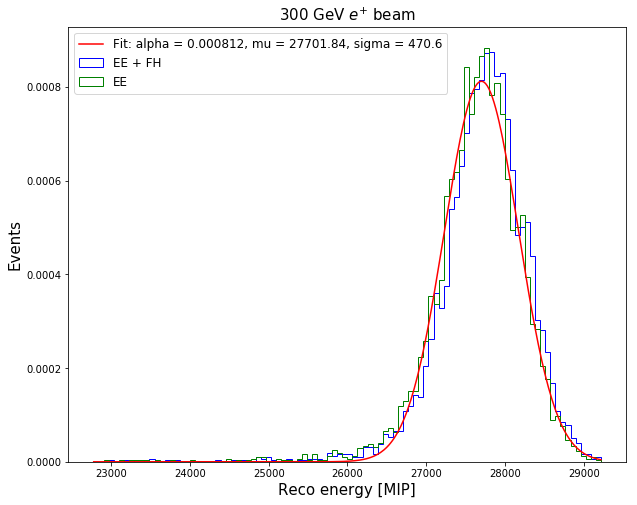

In [6]:
energy = 300
nbins = 100
n, bins = np.histogram(esum_cut, bins=nbins, density=True)
bins_c = (bins[:-1]+bins[1:])/2
mean = np.average(bins_c, weights=n)
var = np.sqrt(np.average((bins_c - mean)**2, weights=n))
xmin = mean - 2*var
xmax = esum_cut.max()
popt, pcov = curve_fit(gauss, bins_c, n, p0 = [n.max(), np.std(bins_c), np.median(bins_c)])

plt.figure(figsize=(10,8))
plt.title(r'%i GeV $e^{+}$ beam' %energy, fontsize=15)
plt.hist(esum, bins=nbins, range=(xmin, xmax), histtype='step', color='blue', density=True, label='EE + FH')
plt.hist(esum_cut, bins=nbins, range=(xmin, xmax), histtype='step', color='green', density=True, label='EE')
plt.plot(np.linspace(xmin,xmax,300), gauss(np.linspace(xmin,xmax,300), *popt), '-', color='red',
    label = u'Fit: alpha = {:f}, mu = {}, sigma = {}'.format(popt[0], round(popt[1],2), round(popt[2],2)))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Reco energy [MIP]', fontsize=15)
plt.ylabel('Events', fontsize=15)

Text(0,0.5,'Events')

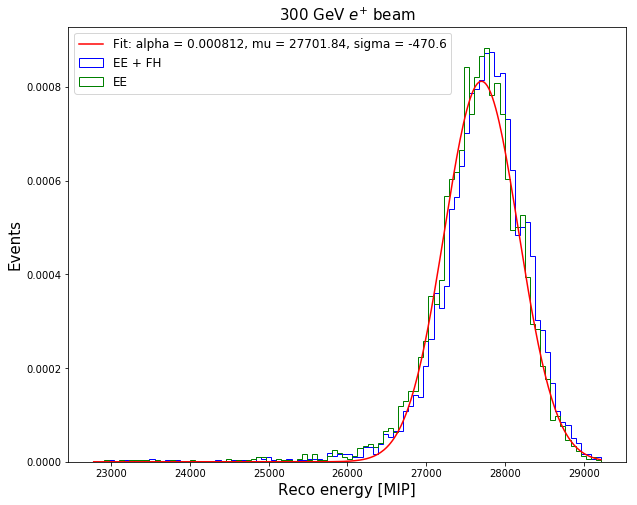

In [7]:
n, bins = np.histogram(esum_cut, bins=nbins, density=True)
bins_c = (bins[:-1]+bins[1:])/2
mean = np.average(bins_c, weights=n)
var = np.sqrt(np.average((bins_c - mean)**2, weights=n))
xmin = mean - 2*var
xmax = esum_cut.max()
[x, y] = cutPoints(bins_c, n, xmin, xmax)
popt1, pcov1 = curve_fit(gauss, x, y, p0 = [n.max(), np.std(bins_c), np.median(bins_c)])

plt.figure(figsize=(10,8))
plt.title(r'%i GeV $e^{+}$ beam' %energy, fontsize=15)
plt.hist(esum, bins=nbins, range=(xmin, xmax), histtype='step', color='blue', density=True, label='EE + FH')
plt.hist(esum_cut, bins=nbins, range=(xmin, xmax), histtype='step', color='green', density=True, label='EE')
plt.plot(np.linspace(xmin,xmax,300), gauss(np.linspace(xmin,xmax,300), *popt1), '-', color='red',
    label = u'Fit: alpha = {:f}, mu = {}, sigma = {}'.format(popt1[0], round(popt1[1],2), round(popt1[2],2)))
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Reco energy [MIP]', fontsize=15)
plt.ylabel('Events', fontsize=15)

In [8]:
energies = np.array([20, 30, 50, 80, 100, 120, 150, 200, 250, 300])
runs = {
    20:  455,
    30:  596,
    50:  458,
    80:  469,
    100: 490,
    120: 620,
    150: 494,
    200: 664,
    250: 653,
    300: 435
}

In [9]:
data_path = '/data_CMS/cms/vernazza/electrons/'
key = 'rechitntupler/hits'
branches = [u'rechit_chip', 'rechit_module', 'rechit_channel', u'rechit_energy', 'rechit_layer', 'beamEnergy']

In [10]:
def EnergySum(fname, branches, key, nentries):

    ttree = uproot.open(fname)[key]
    df = ttree.pandas.df(branches, entrystop=nentries)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']
    #cutting small energies
    df = df[ df['rechit_energy'] > 0.5 ]
    esum = df.groupby('event').rechit_energy.sum()
    
    return esum

In [11]:
def EnergySumSelection(fname, branches, key, nentries):

    #making the panda object
    ttree = uproot.open(fname)[key]
    df = ttree.pandas.df(branches, entrystop=nentries)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']
        
    #cutting small energies
    df = df[ df['rechit_energy'] > 0.5 ]
        
    #getting the total energy for EL and removing the chip 0 of layer 1 because it has presented some deffects
    df_red = df[ (df['rechit_layer'] != 1) | (df['rechit_chip'] != 0) ]
    df_red = df_red[ df_red['rechit_layer'] < 29 ]
    
    esum_cut = df_red.groupby('event').rechit_energy.sum()
        
    return esum_cut

In [12]:
def fitHisto(esum, esum_cut, nbins, energy):
    n, bins = np.histogram(esum_cut, bins=nbins, density=True)
    bins_c = (bins[:-1]+bins[1:])/2
    mean = np.average(bins_c, weights=n)
    var = np.sqrt(np.average((bins_c - mean)**2, weights=n))
    xmin = mean - 2*var
    xmax = min([esum_cut.max(), mean + 2*var])
    popt, pcov = curve_fit(gauss, bins_c, n, p0 = [n.max(), np.std(bins_c), np.median(bins_c)])
    perr = np.sqrt(np.diag(pcov))

    plt.figure(figsize=(10,8))
    plt.title(r'%i GeV $e^{+}$ beam' %energy, fontsize=15)
    plt.hist(esum, bins=nbins, range=(xmin, xmax), histtype='step', color='blue', density=True, label='EE + FH')
    plt.hist(esum_cut, bins=nbins, range=(xmin, xmax), histtype='step', color='green', density=True, label='EE')
    plt.plot(np.linspace(xmin,xmax,300), gauss(np.linspace(xmin,xmax,300), *popt), '-', color='red',
        label = u'Fit: alpha = {:f}, mu = {}, sigma = {}'.format(popt[0], round(popt[1],2), round(popt[2],2)))
    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel('Reco energy [MIP]', fontsize=15)
    plt.ylabel('Events', fontsize=15)
    
    return [popt, abs(perr)]

In [13]:
def fitHistoRange(esum, esum_cut, nbins, energy):
    n, bins = np.histogram(esum_cut, bins=nbins, density=True)
    bins_c = (bins[:-1]+bins[1:])/2
    mean = np.average(bins_c, weights=n)
    var = np.sqrt(np.average((bins_c - mean)**2, weights=n))
    xmin = mean - 2*var
    xmax = min([esum_cut.max(), mean + 2*var])
    [x, y] = cutPoints(bins_c, n, xmin, xmax)
    popt, pcov = curve_fit(gauss, x, y, p0 = [n.max(), mean, var])
    perr = np.sqrt(np.diag(pcov))

    plt.figure(figsize=(10,8))
    plt.title(r'%i GeV $e^{+}$ beam' %energy, fontsize=15)
    plt.hist(esum, bins=nbins, range=(xmin, xmax), histtype='step', color='blue', density=True, label='EE + FH')
    plt.hist(esum_cut, bins=nbins, range=(xmin, xmax), histtype='step', color='green', density=True, label='EE')
    plt.plot(np.linspace(xmin,xmax,300), gauss(np.linspace(xmin,xmax,300), *popt), '-', color='red',
        label = u'Fit: alpha = {:f}, mu = {}, sigma = {}'.format(popt[0], round(popt[1],2), round(popt[2],2)))
    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel('Reco energy [MIP]', fontsize=15)
    plt.ylabel('Events', fontsize=15)
    
    return [popt, abs(perr)]

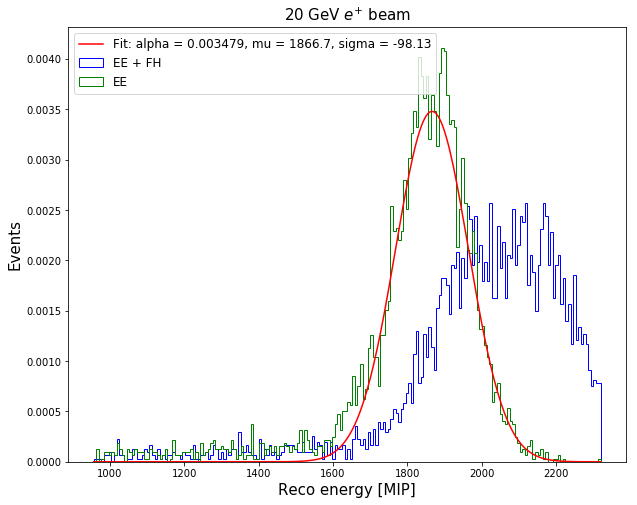

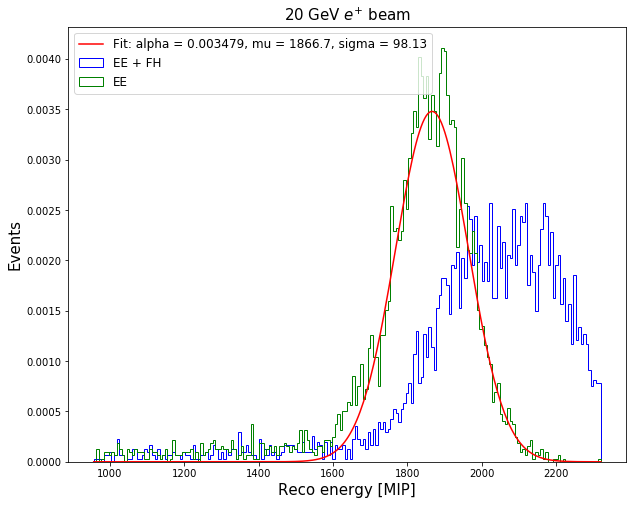

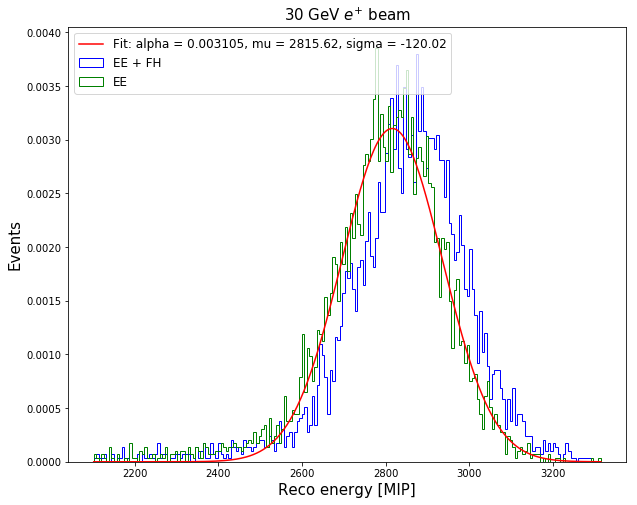

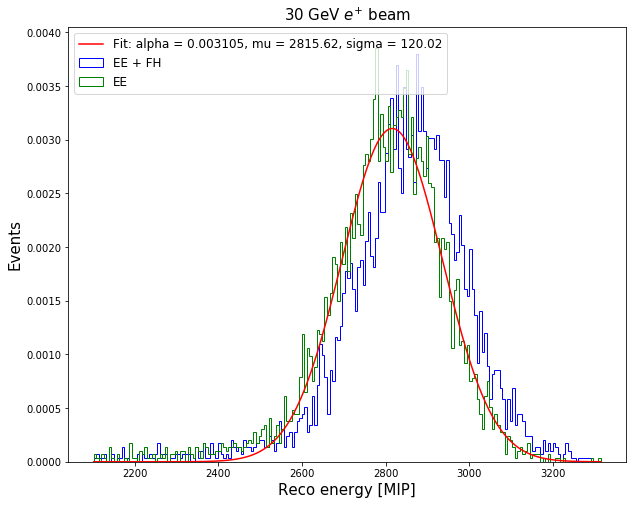

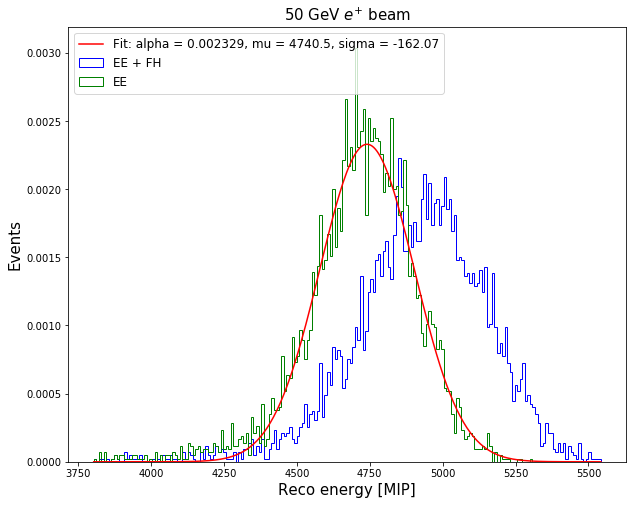

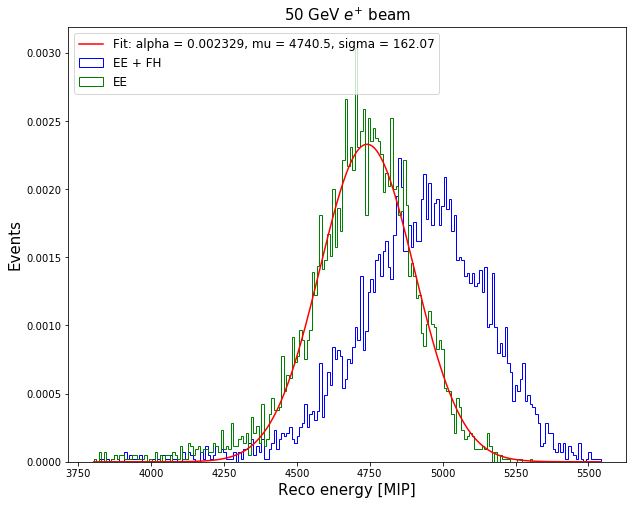

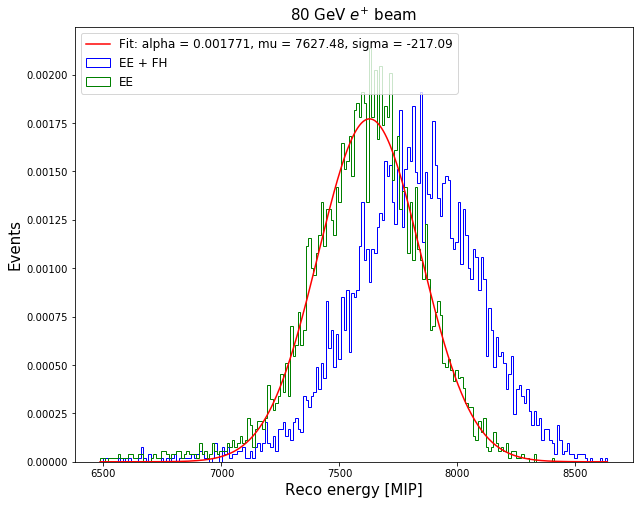

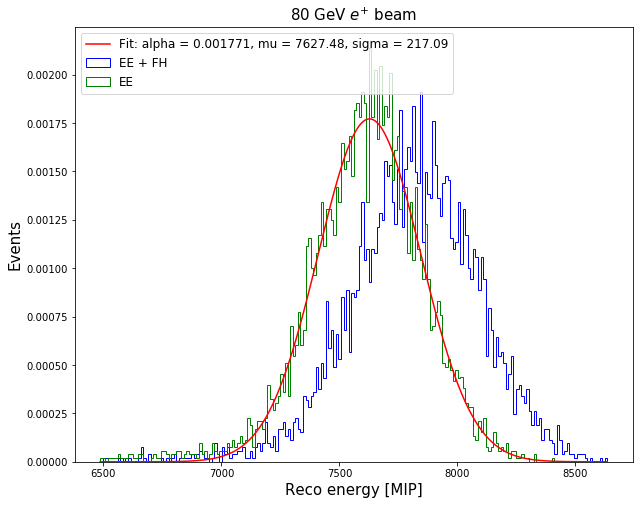

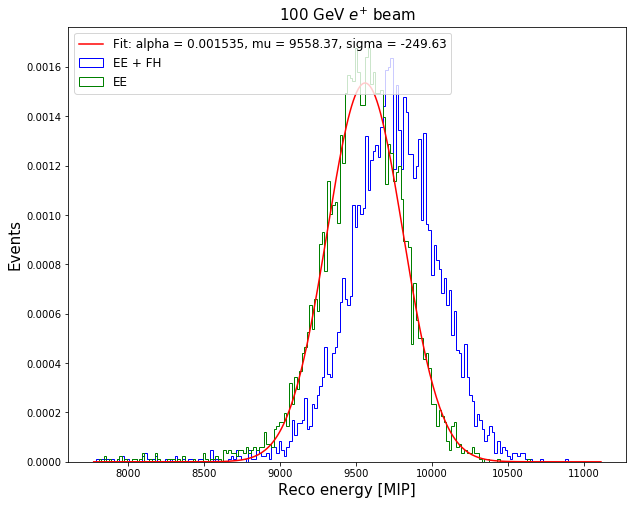

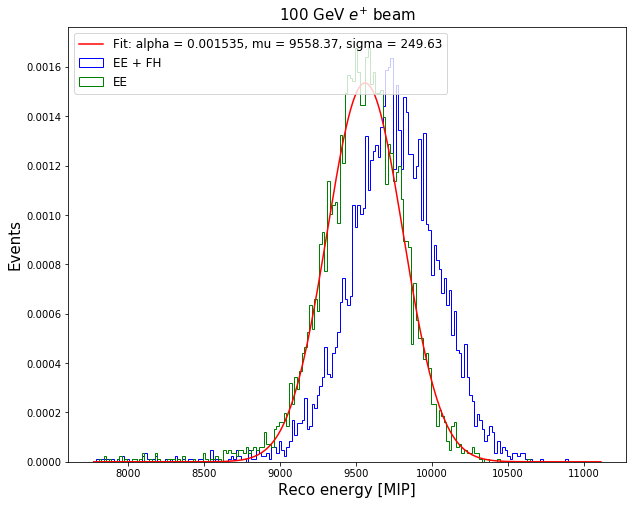

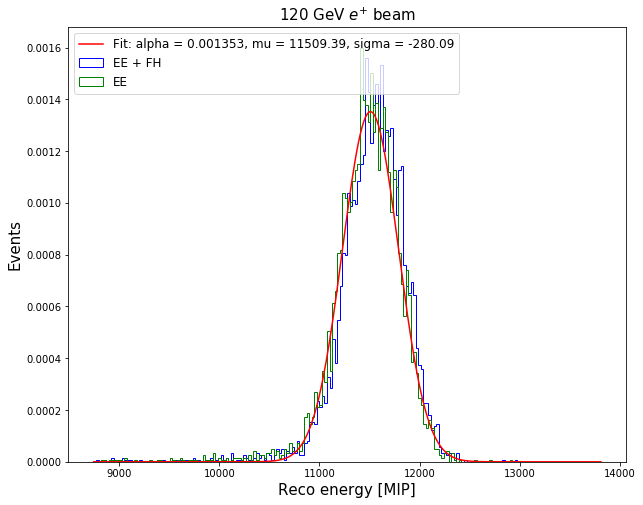

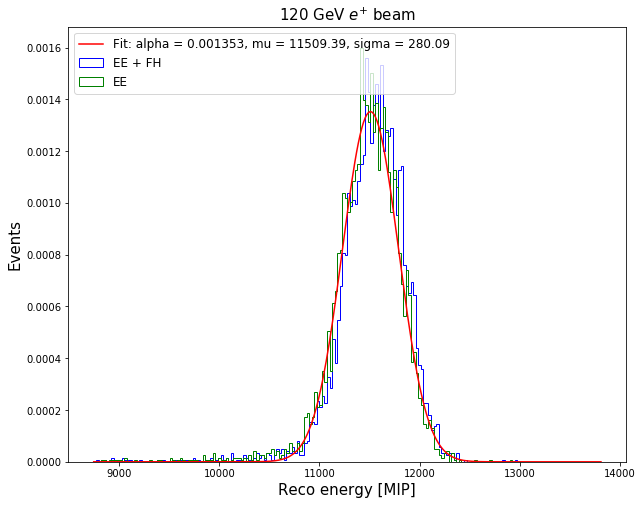

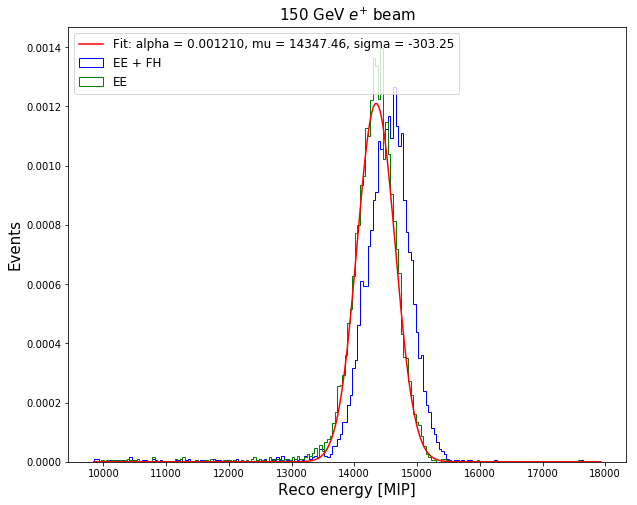

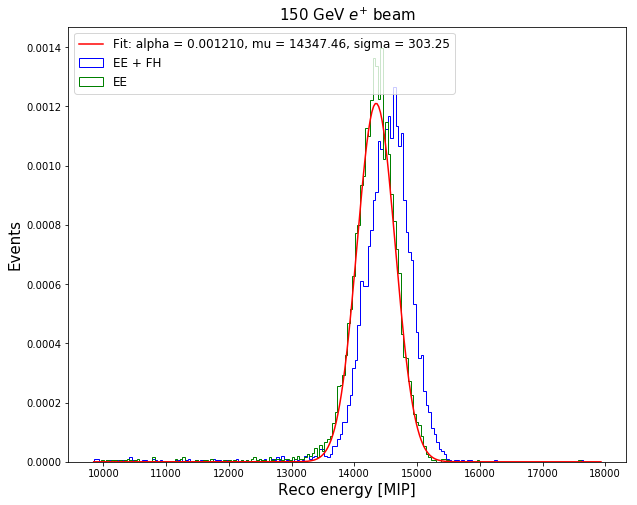

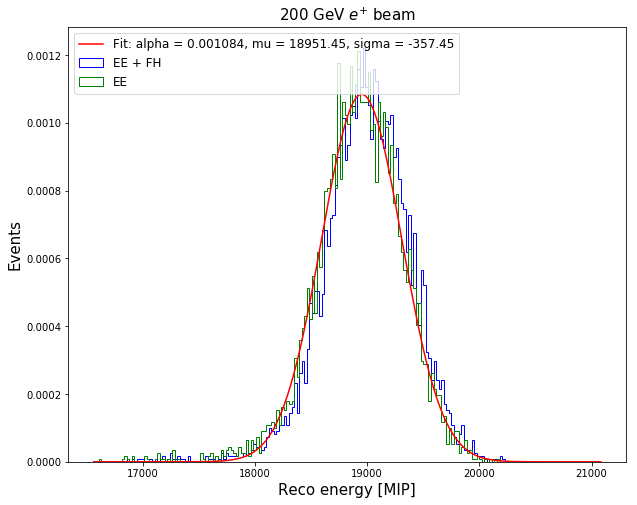

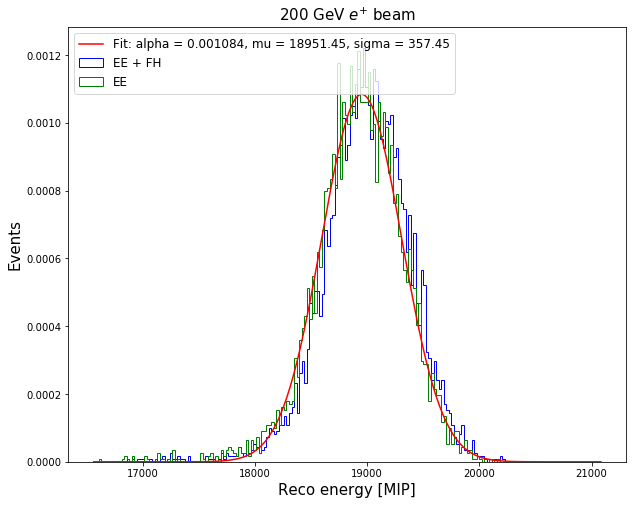

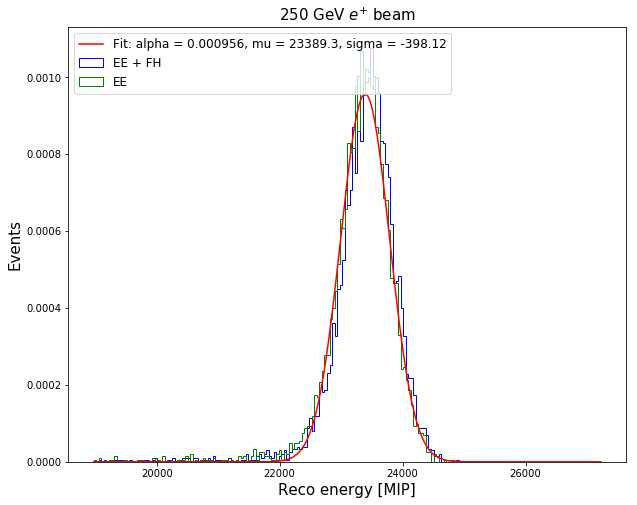

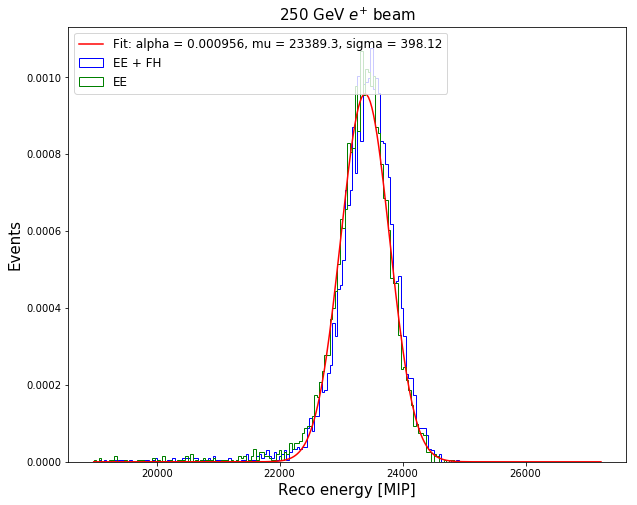

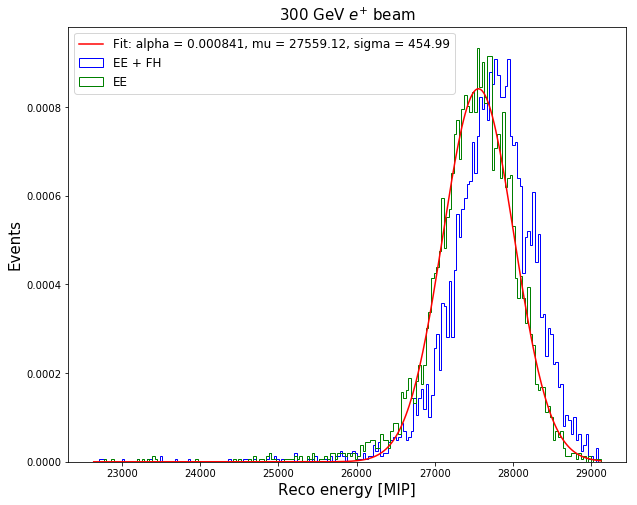

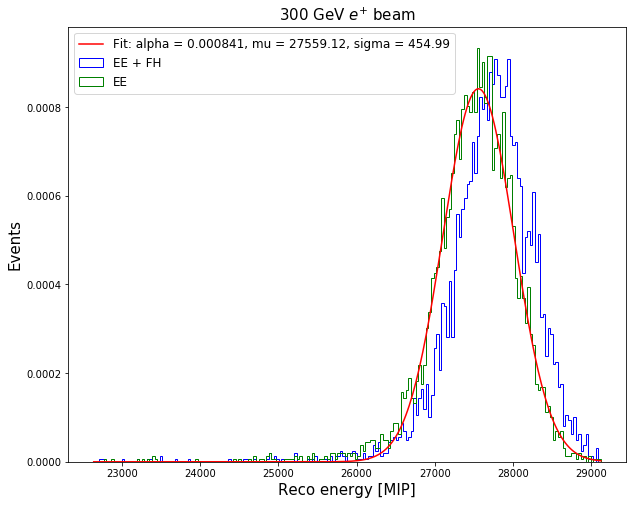

In [14]:
E_0 = []
E_1 = []
E_0_err = []
E_1_err = []
E = []
for i in range(len(energies)):
    energy = energies[i]
    run = runs[energy]
    fname = data_path + 'ntuple_%i.root' %run

    esum = EnergySum(fname, branches, key, 5000)
    esum_cut = EnergySumSelection(fname, branches, key, 5000)
    nbins = 200
    [popt0, perr0] = fitHisto(esum, esum_cut, nbins, energy)
    [popt1, perr1] = fitHistoRange(esum, esum_cut, nbins, energy)

    E_0.append(popt0[1])
    E_1.append(popt1[1])
    E_0_err.append(popt0[2]/np.sqrt(5000))
    E_1_err.append(popt1[2]/np.sqrt(5000))
    E.append(energy)

In [15]:
E_0_err

[-1.3878372600938473,
 -1.6973114783209864,
 -2.2919532906657296,
 -3.070176832485837,
 -3.5302865878570584,
 -3.961043372065353,
 -4.2885572004175705,
 -5.055051820613048,
 -5.630272062359164,
 6.434557591711984]

In [16]:
E_1_err

[1.3878375882913074,
 1.6973117440043364,
 2.291952562910632,
 3.0701766938386448,
 3.530286936265968,
 3.961043053396711,
 4.288556655464674,
 5.055051692726742,
 5.630272831197534,
 6.434556415691155]

In [17]:
def linear(x, a, b):
    return (a*x + b)

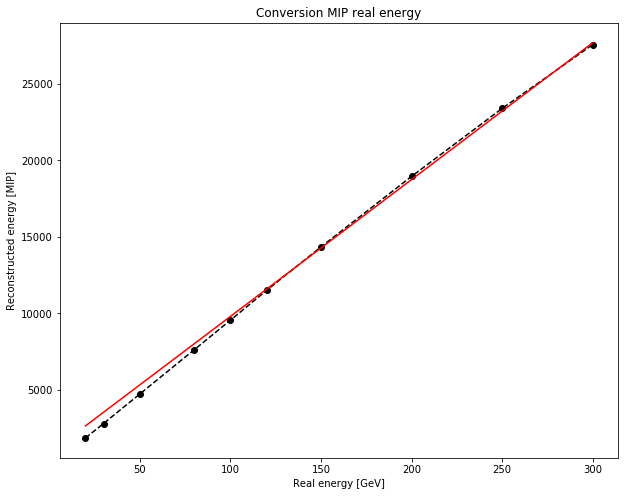

In [18]:
E_0 = np.array(E_0)
E_0_err = np.array(E_0_err)
E = np.array(E)
p0, p0_cov = curve_fit(linear, E, E_0, p0=[1.0,1.0], sigma=1/E_0_err**2) #try with and without errors
fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title('Conversion MIP real energy')
ax.plot(E, E_0, 'ko--')
#ax.errorbar(E, E_0, yerr=E_0_err, xerr=0)
ax.set_xlabel('Real energy [GeV]')
ax.set_ylabel('Reconstructed energy [MIP]')
plt.plot(E, linear(E, *p0), 'r-', label='Fitted function', color='Red')

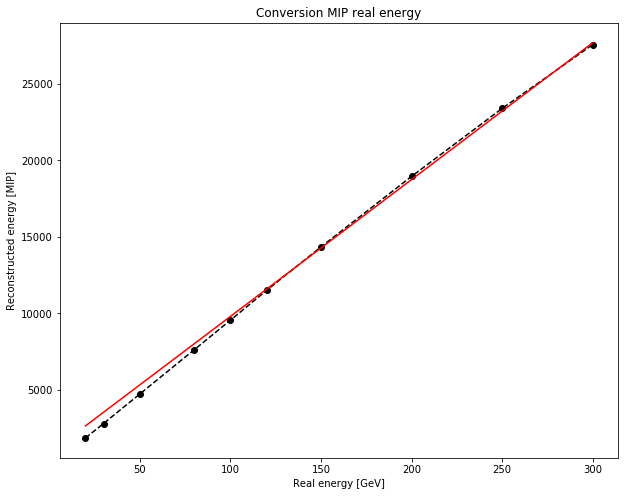

In [19]:
E_1 = np.array(E_1)
E_1_err = np.array(E_1_err)
E = np.array(E)
p1, p1_cov = curve_fit(linear, E, E_1, p0=[1.0,1.0], sigma=1/E_1_err**2) #try with and without errors
fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title('Conversion MIP real energy')
ax.plot(E, E_1, 'ko--')
ax.set_xlabel('Real energy [GeV]')
ax.set_ylabel('Reconstructed energy [MIP]')
plt.plot(E, linear(E, *p1), 'r-', label='Fitted function', color='Red')

In [20]:
from IPython.display import display, Math
display(Math(r'\alpha = {} \pm{}'.format(round(p0[0], 2), round(np.sqrt(p0_cov[0][0]),2))))
display(Math(r'\mu = {} \pm{}'.format(round(p0[1], 2), round(np.sqrt(p0_cov[1][1]),2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
from IPython.display import display, Math
display(Math(r'\alpha = {} \pm{}'.format(round(p1[0], 2), round(np.sqrt(p1_cov[0][0]),2))))
display(Math(r'\mu = {} \pm{}'.format(round(p1[1], 2), round(np.sqrt(p1_cov[1][1]),2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>